In [609]:
import os
os.environ["EXPERIMENT_ROOT"] = "/mnt/home/acanatar/ceph/manifold-experiments"

import hydra
from hydra import initialize, compose
from omegaconf import OmegaConf

try:
    initialize(version_base=None, config_path="configs")
except:
    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(version_base=None, config_path="configs")
    
cfg=compose(config_name="mmcr_train.yaml",
            overrides=["+model.projection_kwargs.features=[2048,512,128]",
                       'model.manifold_loss="dimensionality"',
                       "batch_size=4096",
                       "dataset.frames_per_clip=6"])

# print(OmegaConf.to_yaml(cfg, resolve=True));

In [610]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.linalg import svdvals

from timm import create_model, list_models

torch.Size([6, 1, 64, 64])

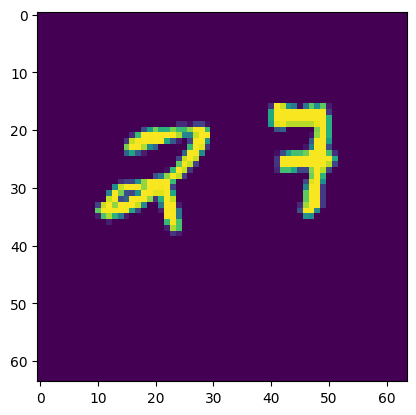

In [611]:
from torch.utils.data import DataLoader, Dataset
from manifold_experiments.datasets import VideoDataset
from manifold_experiments.utils.manifold_statistics import (
    extract_activations,
    get_feature_extractor,
    make_manifold_data,
    manifold_analysis,
)

# Load dataset
train_dataset = VideoDataset(
    name=cfg.dataset.train_name,
    frames_per_clip=cfg.dataset.frames_per_clip,
    **cfg.dataset.train_kwargs,
)
val_dataset = VideoDataset(
    name=cfg.dataset.val_name,
    frames_per_clip=cfg.dataset.frames_per_clip,
    **cfg.dataset.val_kwargs,
)

manifold_train_dataset = VideoDataset(
    name=cfg.manifold.train_dataset,
    **cfg.manifold.train_dataset_kwargs,
)
manifold_val_dataset = VideoDataset(
    name=cfg.manifold.val_dataset,
    **cfg.manifold.val_dataset_kwargs,
)


train_dataloader = DataLoader(
        train_dataset,
        batch_size=cfg.batch_size,
        shuffle=cfg.shuffle,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory,
    )


val_dataloader = DataLoader(
        val_dataset,
        batch_size=cfg.batch_size,
        shuffle=cfg.shuffle,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory,
    )


for inp in train_dataset:
    plt.imshow(inp[0][5].squeeze())
    break

inp[0].shape

In [612]:
from manifold_experiments.constants import HEADS, OPTIMIZERS

from manifold_experiments.manifold_models import (
    MMCRTwoStageTwoHeadPredictor,
    ProjectionHead,
    TwoStageTwoHeadPredictor,
    create_encoder,
)

In [613]:
cfg.model.type

'mmcr'

In [614]:
encoder = create_encoder(
    model_name=cfg.model.encoder.type,
    weights=cfg.model.encoder.weights,
    **cfg.model.encoder.kwargs,
)

model_type = (
        TwoStageTwoHeadPredictor
        if cfg.model.type == "default"
        else MMCRTwoStageTwoHeadPredictor
    )

model = model_type(
    encoder=encoder,

    linear_head=HEADS[cfg.model.classification_type](**cfg.model.classification_kwargs)
    if OmegaConf.select(cfg, "model.classification_type")
    else None,

    autoregressive_head=HEADS[cfg.model.autoregressive_type](**cfg.model.autoregressive_kwargs)
    if OmegaConf.select(cfg, "model.autoregressive_type")
    else None,

    projector=ProjectionHead(**cfg.model.projection_kwargs)
    if OmegaConf.select(cfg, "model.projection_kwargs")
    else nn.Identity(),

    norm=OmegaConf.select(cfg, "model.norm"),

    manifold_loss=OmegaConf.select(cfg, "model.manifold_loss", default="capacity"),
)


# Freeze layers up until the specified layer, if present
if OmegaConf.select(cfg, "model.freeze_until"):
    for name, param in model.named_parameters():
        if cfg.model.freeze_until != "all" and cfg.model.freeze_until in name:
            break
        param.requires_grad = False

In [615]:
from manifold_experiments.utils.knn import manifold_knn
from manifold_experiments.utils.least_square_regression import manifold_lstsq
from manifold_experiments.utils.manifold_statistics import (
    extract_activations,
    get_feature_extractor,
    make_manifold_data,
    manifold_analysis,
)

sampled_manifold_dataset = make_manifold_data(
    manifold_train_dataset,
    cfg.manifold.sampled_classes,
    cfg.manifold.examples_per_class,
)

results = {}
for data, label in train_dataloader:

    with torch.no_grad():

        # latents = model.get_latent(data)
        latents = model.get_projection(data)
        assert len(latents.shape) == 3, \
            'latents must have shape (batch, frame, features))'

        latents = F.normalize(latents, p=2, dim=-1)
        centroid = latents.mean(dim=1)

        # SVD of centroids - shape (min(batch, feature))
        S_c = svdvals(centroid)
        # SVD of latents - shape (batch, min(frame, feature))
        S_z = svdvals(latents)

        S_c = S_c.abs() / math.sqrt(max(centroid.shape))
        S_z = S_z.abs() / math.sqrt(max(latents.shape[1:]))

        rad_c = (S_c**2).sum().sqrt()
        dim_c = S_c.sum()**2 / rad_c**2 / S_c.shape[0]
        alpha_c = rad_c * dim_c.sqrt()

        rad_z = (S_z**2).sum(-1).sqrt()
        dim_z = S_z.sum(-1)**2 / (S_z**2).sum(-1) / S_z.shape[-1]
        alpha_z = rad_z * dim_z.sqrt()

        result = {'rad_c': rad_c.item(),
                  'dim_c': dim_c.item(),
                  'alpha_c': alpha_c.item(),
                  'rad_z': rad_z.mean().item(),
                  'dim_z': dim_z.mean().item(),
                  'alpha_z': alpha_z.mean().item()}

        results[cfg.batch_size] = result

    break

torch.Size([4096, 128]) torch.Size([4096, 6, 128])
torch.Size([128]) torch.Size([4096, 6])


In [616]:
batch_sizes = np.array([key for key in results.keys()])
result_array = {key: [] for key in results[batch_sizes[0]]}

for batch in batch_sizes:
    for key, item in results[batch].items():
        result_array[key] += [item]
        
for key, item in result_array.items():
    result_array[key] = np.array([item]).flatten()
    

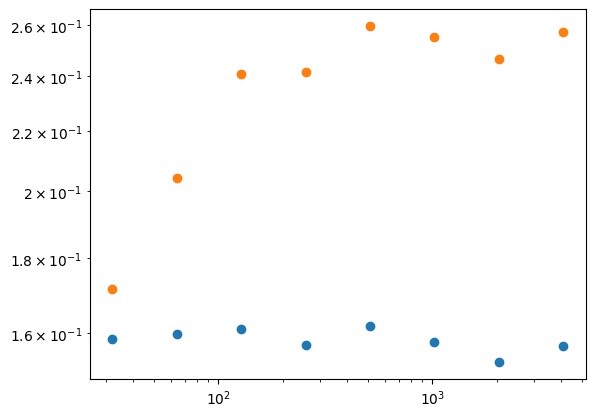

In [620]:
plt.loglog(batch_sizes, result_array['alpha_z'], 'o')
plt.loglog(batch_sizes, result_array['alpha_c'], 'o')


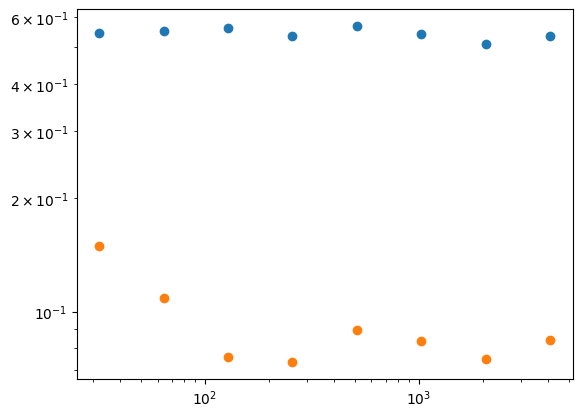

In [622]:
plt.loglog(batch_sizes, result_array['dim_z'], 'o')
plt.loglog(batch_sizes, result_array['dim_c'], 'o')

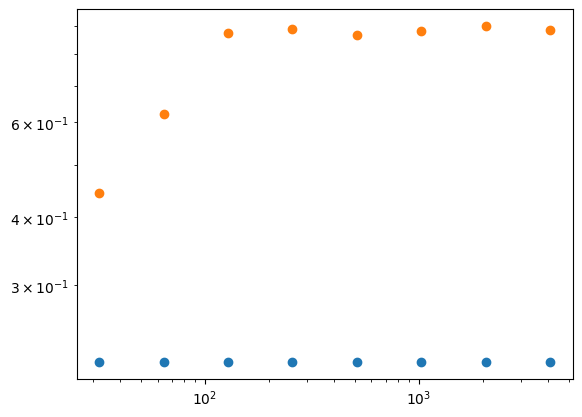

In [623]:
plt.loglog(batch_sizes, result_array['rad_z'], 'o')
plt.loglog(batch_sizes, result_array['rad_c'], 'o')

In [8]:
def manifold_lstsq(
    module: nn.Module,
    manifold_val_data: Dataset,
    eps: float = 1e-6,
    batch_size: int = 128,
    num_workers: int = 2,
):
    """Least squares regression evaluation on manifold data.

    Args:
    module : nn.Module
        Model to evaluate
    manifold_val_data : Dataset
        val data for the manifold
    eps : float, optional
        Epsilon for numerical stability, by default 1e-10
    batch_size : int, optional
        Batch size for the dataloader, by default 128
    num_workers : int, optional
        Number of workers for the dataloader, by default 2

    Returns:
    dict
        Dictionary containing mean r_squared and mean rank

    """
    device = next(module.parameters()).device

    manifold_val_dataloader = DataLoader(
        manifold_val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    module.eval()
    with torch.no_grad():
        coeffs_of_determination = torch.tensor([])
        ranks = torch.tensor([])
        for data, _ in tqdm(manifold_val_dataloader, desc="Manifold Val LSTSQ"):
            data = data.to(device)

            # acts shape from (batch_size, frames, features) to (batch_size, features, frames)
            # acts = module.get_latent(data).permute(0, 2, 1).type(torch.DoubleTensor)
            acts = module.get_projection(data).permute(0, 2, 1).type(torch.DoubleTensor)

            
            # Compute the least squares regression coefficients
            X, y = acts[:, :, :-1], acts[:, :, -1].unsqueeze(2)     
            coef, residuals, rank, s = torch.linalg.lstsq(X, y, rcond=None)
            y_pred = torch.bmm(X, coef)

            total_sum_of_squares = torch.sum(
                (y - y.mean(dim=(1), keepdim=True)) ** 2, dim=1
            )
            residual_sum_of_squares = torch.sum((y - y_pred) ** 2, dim=1)
            r_squared = 1 - (
                residual_sum_of_squares / (total_sum_of_squares + eps)
            ).clamp_(0, 1)

            # Perform least squares regression between the last feature and the first features
            coeffs_of_determination = torch.cat(
                [coeffs_of_determination, r_squared.flatten().cpu()]
            )

            ranks = torch.cat([ranks, rank.flatten().cpu()])

    # Return the mean of the r_squared values and the ranks
    return {
        "mean_r_squared": torch.mean(coeffs_of_determination).item(),
        "mean_rank": torch.mean(ranks).item(),
    }

manifold_val_dataloader = DataLoader(
        val_dataset, batch_size=128, shuffle=False, num_workers=5
    )

manifold_lstsq(model, val_dataset)

Manifold Val LSTSQ:   0%|          | 0/79 [00:00<?, ?it/s]

Manifold Val LSTSQ: 100%|██████████| 79/79 [00:27<00:00,  2.85it/s]


{'mean_r_squared': 0.9922868912926438, 'mean_rank': 4.542900085449219}